In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import torchvision.models as models
from torchvision import transforms
from PIL import Image



sns.set()

In [5]:
CIFAR = np.load('./datasets/CIFAR.npz')
FM0_5 = np.load('./datasets/FashionMNIST0.5.npz')
FM0_6 = np.load('./datasets/FashionMNIST0.6.npz')

In [9]:
def plot_image(dataset):
    fig,axes=plt.subplots(2 ,3,figsize=(10,7))
    for i in range(6):
        if i <3:
            axes[0,i].imshow(dataset['Xtr'][i])
        else: 
            axes[1,i-3].imshow(dataset['Xtr'][i])


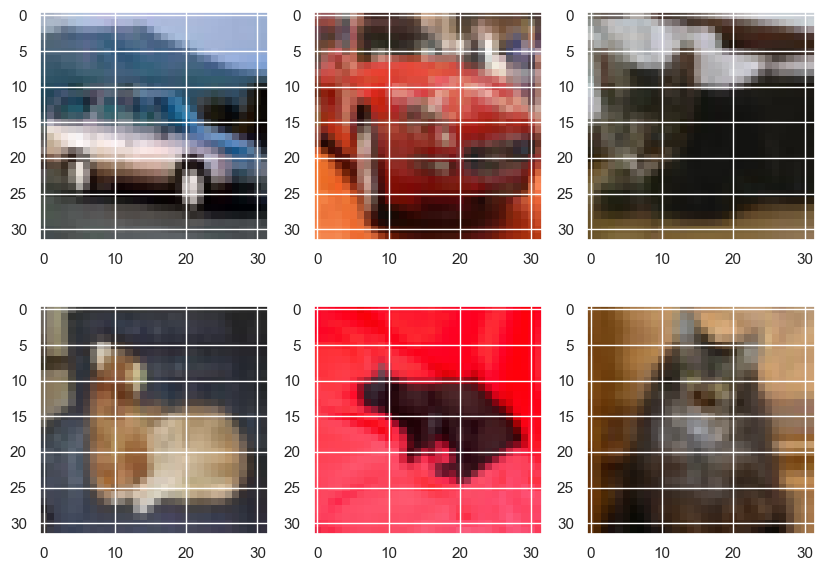

In [32]:
plot_image(CIFAR)

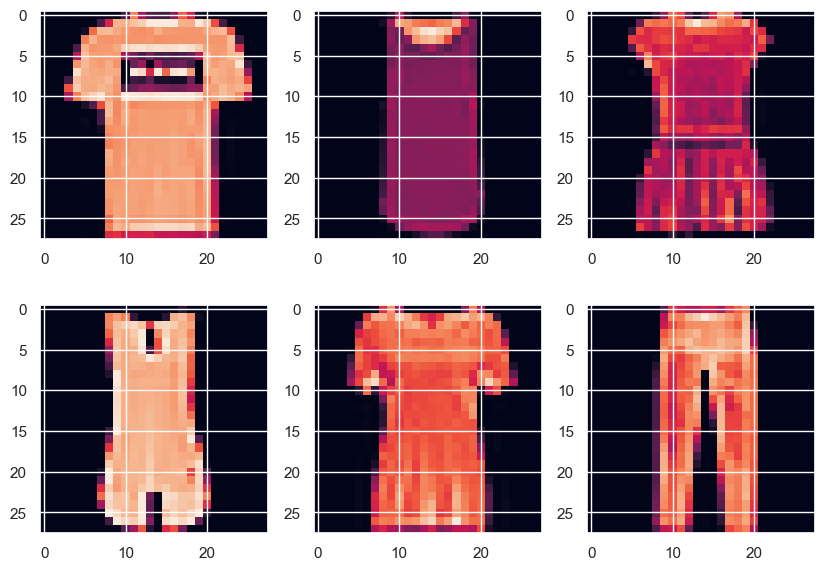

In [33]:
plot_image(FM0_5)

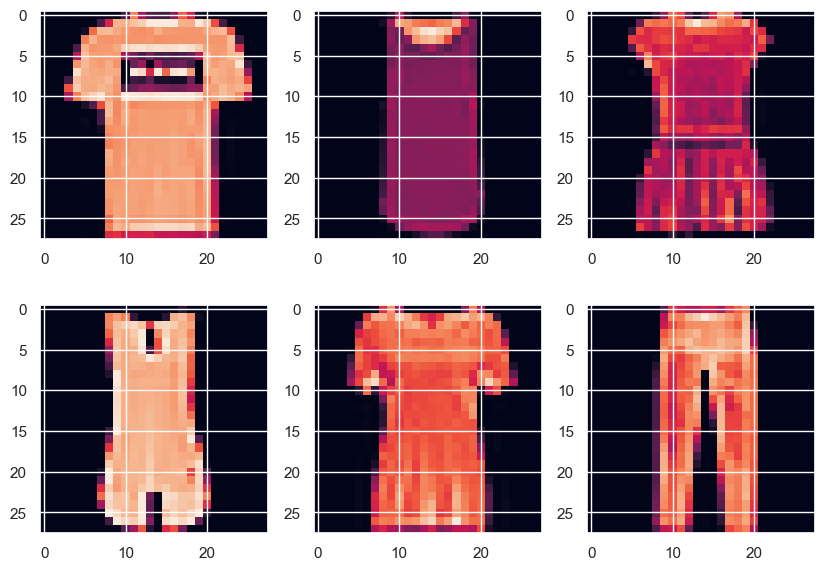

In [34]:
plot_image(FM0_6)

In [44]:
class DatasetArray(Dataset):
    def __init__(self,features,labels,transform):
        self.features=features
        self.labels=labels
        self.transform=transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,index):
        features=self.features[index]
        labels=self.labels[index]
        #features = Image.fromarray(features.astype(np.uint8))
        features_np = features.numpy()

        # Convert NumPy array to PIL Image
        features= Image.fromarray((features_np * 255).astype('uint8').transpose(1, 2, 0))
        
        if self.transform is not None:
            features=self.transform(features)
            print(features.shape)
        return (features,labels)

In [49]:
def dataloader(dataset):
    train_features=dataset['Xtr']
    train_labels=dataset['Str']
    train_labels = torch.from_numpy(train_labels)
    train_labels=torch.nn.functional.one_hot(train_labels, num_classes=3).float()
    test_features=dataset['Xts']
    test_labels=dataset['Yts']
    test_labels = torch.from_numpy(test_labels)
    test_labels=torch.nn.functional.one_hot(test_labels, num_classes=3).float()
    x_train,x_val,y_train,y_val=train_test_split(train_features,train_labels,test_size=0.2)
    x_train=torch.from_numpy(x_train.astype(np.float32) / 255).permute(0, 3, 1, 2)
    x_val=torch.from_numpy(x_val.astype(np.float32) / 255).permute(0, 3, 1, 2)
    x_test=torch.from_numpy(test_features.astype(np.float32) / 255).permute(0, 3, 1, 2)
    #batch load
    data_transform = {
    "train": transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    #transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    "val": transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    "test":transforms.Compose([transforms.ToTensor()])}
    train_dataset=DatasetArray(x_train,y_train,transform=data_transform["train"])
    val_dataset=DatasetArray(x_val,y_val,transform=data_transform["val"])
    # train_dataset=DatasetArray(x_train,y_train)
    # val_dataset=DatasetArray(x_val,y_val)
    test_data=DatasetArray(x_test,test_labels,transform=data_transform["test"])
    
    train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
    val_loader=DataLoader(val_dataset,batch_size=64,shuffle=True)
    test_loader=DataLoader(test_data,batch_size=64,shuffle=True)

    return train_loader,val_loader,test_loader


In [50]:
train_loader,val_loader,test_loader=dataloader(CIFAR)

In [51]:
# 假设 train_loader 是你的 DataLoader 对象
for batch_images, batch_labels in test_loader:
    # 查看第一个图像的尺寸
    print(batch_images[0].shape)
    break  # 只查看第一个批次即可


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 3

## lenet

In [9]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet,self).__init__()
        self.conv1=nn.Conv2d(3,6,5,stride=1,padding=0)
        self.conv2=nn.Conv2d(6,6,5)
        self.fc1=nn.Linear(150,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,3)

    def forward(self,x):
        out=F.relu(self.conv1(x))
        out=F.max_pool2d(out,2)
        out=F.relu(self.conv2(out))
        out=F.max_pool2d(out,2)
        out=out.view(out.size(0),-1)
        out=F.relu(self.fc1(out))
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return out
        


## resnet

In [13]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

In [24]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.T_revision = nn.Linear(num_classes, num_classes, False)
        
           
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #correction = self.T_revision.weight
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        # if revision == True:
        #     return out, correction
        # else:
        return out
        
def ResNet18(num_classes):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

In [29]:
##pre train model
resnet18 = models.resnet18(pretrained=True)

/Users/jiawen/anaconda3/envs/ai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jiawen/anaconda3/envs/ai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/jiawen/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.51MB/s]


In [41]:
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 3)
# for i in resnet18.parameters():
#     i.requires_grad=False

### resnet fix param

In [20]:
weights = models.ResNet18_Weights.DEFAULT

class ResNet18Impl(nn.Module):
    def __init__(self, output_shape):
        super(ResNet18Impl, self).__init__()

        self.pretrained = models.resnet18(weights=weights)
        for param in self.pretrained.parameters():
            param.requires_grad = False
        

        pretrained_output = self.pretrained.fc.out_features
        self.fc = torch.nn.Sequential(
            nn.Linear(in_features=pretrained_output,

                      out_features=output_shape,
                      bias=False),
        )

    def forward(self, image):
        output = self.pretrained(image)
        output = self.fc(output)
        return output

model_resnet = ResNet18Impl(output_shape=3)


## train

In [10]:
def train(model, criterion, optimizer, training_dataloader):
    sum_accuracy = 0
    sum_loss = 0
    count = 0
    model.train()
    for features, labels in training_dataloader:
        probabilities=model(features)
        #print(probabilities)
        loss=criterion(probabilities,labels)
        #print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mini_batch_size=labels.size(0)
        labels=torch.argmax(labels, dim=1)
        accuracy=(
            torch.sum(torch.max(probabilities,dim=1).indices==labels)
        )

        sum_accuracy+=accuracy.item()
        sum_loss+=loss.item()*mini_batch_size
        #print(sum_loss)
        count+=mini_batch_size
        #print(sum_loss/count)
        train_acc=sum_accuracy/count
        train_loss=sum_loss/count
    return train_acc, train_loss



In [11]:
def validate(model,criterion,dataloader):
    sum_accuracy=0
    sum_loss=0
    count=0
    model.eval()
    for features ,labels in dataloader:
        
        with torch.no_grad():
            probabilities=model(features)
            loss=criterion(probabilities,labels)
        mini_batch_size=labels.size(0)
        labels=torch.argmax(labels, dim=1)
        accuracy=(
            torch.sum(torch.max(probabilities,dim=1).indices==labels)
        )

        sum_accuracy+=accuracy.item()
        sum_loss+=loss.item()*mini_batch_size
        #print(sum_loss)
        count+=mini_batch_size
        #print(sum_loss/count)
    val_acc=sum_accuracy/count
    val_loss=sum_loss/count

    return val_acc, val_loss
    

In [12]:
def evaluate(dataset,model):
    x_test=dataset["Xts"]
    y_test=dataset["Yts"]
    x_test=torch.from_numpy(x_test.astype(np.float32) / 255).permute(0, 3, 1, 2)
    cifar_xtest=torch.Tensor(x_test)
    y_pred=torch.max(model(cifar_xtest),dim=1).indices
    correct=0
    for index , value in enumerate(y_pred):
        if value == y_test[index]:
            correct += 1
    #report=classification_report(y_test,y_pred.numpy())
    precision,recall,_,_=precision_recall_fscore_support(y_test,y_pred,average='weighted')
    return precision, recall

In [21]:
import torch
data=torch.tensor([[1,2,3],[4,2,1]])
data1=torch.cat([data,data],dim=0)
data2=data@(data.T)
data2


tensor([[14, 11],
        [11, 21]])

In [21]:
def run(dataset,epochs=10,lr=0.01):

    train_loader,val_loader,test_loader=dataloader(dataset)
    #model=resnet18
    #model=Lenet()
    model=model_resnet
    # resnet18 = resnet18.fc.in_features
    # resnet18.fc = nn.Linear(num_ftrs, 3)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        train_acc, train_loss=train(model,criterion, optimizer, train_loader)
        val_acc, val_loss=validate(model,criterion, val_loader)
        test_acc, test_loss=validate(model,criterion, test_loader)

        training_accuracies.append(train_acc)
        training_losses.append(train_loss)
        validation_accuracies.append(val_acc)
        validation_losses.append(val_loss)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)


        print(f"epoch: {epoch}\n \
            train_acc: {train_acc}, train_loss: {train_loss}\n \
            val_acc: {val_acc}, val_loss: {val_loss}\n \
            test_acc: {test_acc}, test_loss: {test_loss}\n")
    precision,recall=evaluate(dataset,model)


    return (training_accuracies,training_losses,
            validation_accuracies,
            validation_losses,
            test_accuracies,
            test_losses,
            precision,
            recall,
            model)


        



In [68]:
def plot1(run,test_acc,train_loss,val_loss):
    for i in range(run):
        df=pd.DataFrame()
        df['test_acc_df']=pd.DataFrame([test_acc[i]])
        df['train_loss_df']=pd.DataFrame([train_loss[i]])
        df['val_acc_df']=pd.DataFrame([val_loss[i]])
        plt.plot(df['test_acc_df'],label='test_acc')
        plt.plot(df['train_loss_df'], label='train_loss')
        plt.plot(df['val_loss_df'], label='val_loss')
        plt.legend()
        # 添加标签和标题
        plt.xlabel('batch size')
        plt.ylabel('Values')


In [15]:
def plot2(run,test_accuracies,training_accuracies,training_losses,title):
    a=[]
    for i in range(run):
        a.append(i)
    plt.plot(a,test_accuracies,'r--',label='test_accuracy')
    plt.plot(a,training_losses,'b',label='train_loss')
    plt.plot(a,training_accuracies,'^y:',label='train_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.title(title)

In [45]:
import torch.nn as nn 
m = nn.AdaptiveAvgPool2d((1, 1))
input = torch.randn(1, 64, 8, 9)
output = m(input)
output.shape
# input.shape

torch.Size([1, 64, 1, 1])

### lenet

In [14]:
(training_accuracies,training_losses,
validation_accuracies,
validation_losses,
test_accuracies,
test_losses,
precision,
recall,
model)=run(CIFAR,epochs=5,lr=0.01)

epoch: 0
             train_acc: 0.3358333333333333, train_loss: 1.0986337083180746
             val_acc: 0.32566666666666666, val_loss: 1.0987077379226684
             test_acc: 0.334, test_loss: 1.09815008354187

epoch: 1
             train_acc: 0.33841666666666664, train_loss: 1.098611182530721
             val_acc: 0.33, val_loss: 1.098684095700582
             test_acc: 0.36933333333333335, test_loss: 1.098046550432841

epoch: 2
             train_acc: 0.33258333333333334, train_loss: 1.0985803012847901
             val_acc: 0.332, val_loss: 1.0987482086817424
             test_acc: 0.357, test_loss: 1.0979881525039672

epoch: 3
             train_acc: 0.33858333333333335, train_loss: 1.0985574226379395
             val_acc: 0.3293333333333333, val_loss: 1.0986802797317505
             test_acc: 0.345, test_loss: 1.097880893389384

epoch: 4
             train_acc: 0.3396666666666667, train_loss: 1.0985470695495605
             val_acc: 0.335, val_loss: 1.0986513843536376
         

/Users/jiawen/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


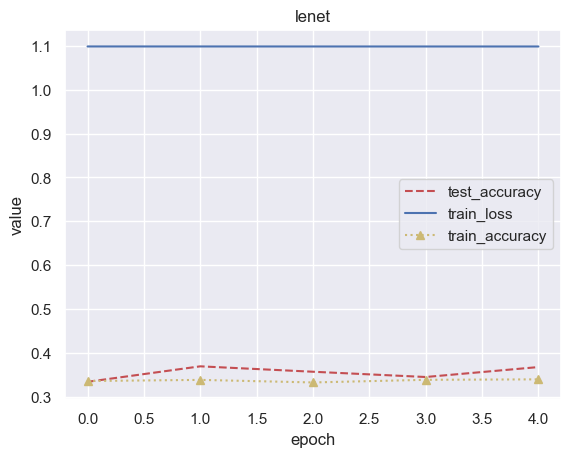

In [16]:
plot2(5,test_accuracies,training_accuracies,training_losses,'lenet')

### resnet

In [76]:
(training_accuracies,training_losses,
validation_accuracies,
validation_losses,
test_accuracies,
test_losses,
precision,
recall,
model)=run(CIFAR,epochs=5,lr=0.01)

epoch: 0
             train_acc: 0.42133333333333334, train_loss: 1.0702301909128824
             val_acc: 0.419, val_loss: 1.0705754995346068
             test_acc: 0.449, test_loss: 1.0604643815358479

epoch: 1
             train_acc: 0.48391666666666666, train_loss: 1.0157968943913778
             val_acc: 0.3933333333333333, val_loss: 1.1525977029800416
             test_acc: 0.43366666666666664, test_loss: 1.084655571937561

epoch: 2
             train_acc: 0.5414166666666667, train_loss: 0.9484823077519735
             val_acc: 0.3903333333333333, val_loss: 1.2679913155237834
             test_acc: 0.38233333333333336, test_loss: 1.2714501234690347

epoch: 3
             train_acc: 0.6026666666666667, train_loss: 0.8538221874237061
             val_acc: 0.394, val_loss: 1.3047830222447714
             test_acc: 0.4226666666666667, test_loss: 1.2524202934900919

epoch: 4
             train_acc: 0.6580833333333334, train_loss: 0.7632448434829712
             val_acc: 0.395333333333

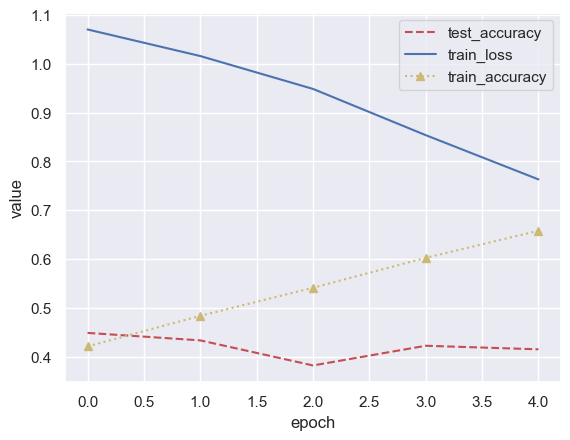

In [90]:
plot2(5,test_accuracies,training_accuracies,training_losses)

### resnet fix param

In [22]:
(training_accuracies,training_losses,
validation_accuracies,
validation_losses,
test_accuracies,
test_losses,
precision,
recall,
model)=run(CIFAR,epochs=5,lr=0.01)

epoch: 0
             train_acc: 0.33791666666666664, train_loss: 2.1009737955729166
             val_acc: 0.3283333333333333, val_loss: 2.480566618601481
             test_acc: 0.38066666666666665, test_loss: 2.191414013544718

epoch: 1
             train_acc: 0.34408333333333335, train_loss: 2.0068965082168577
             val_acc: 0.348, val_loss: 2.3019672978719075
             test_acc: 0.45966666666666667, test_loss: 1.646562426884969

epoch: 2
             train_acc: 0.34, train_loss: 2.036928291320801
             val_acc: 0.3253333333333333, val_loss: 3.3814482154846193
             test_acc: 0.326, test_loss: 3.3607445570627847

epoch: 3
             train_acc: 0.34658333333333335, train_loss: 2.0540610567728677
             val_acc: 0.33466666666666667, val_loss: 2.2926603139241535
             test_acc: 0.38433333333333336, test_loss: 2.009545584996541

epoch: 4
             train_acc: 0.3485, train_loss: 2.0310901788075766
             val_acc: 0.3433333333333333, val_loss

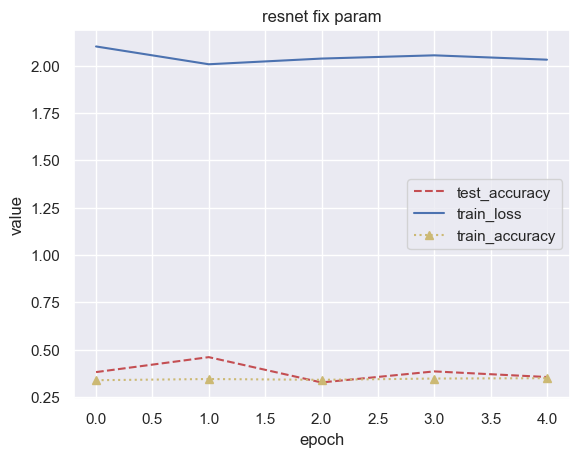

In [23]:
plot2(5,test_accuracies,training_accuracies,training_losses,'resnet fix param')